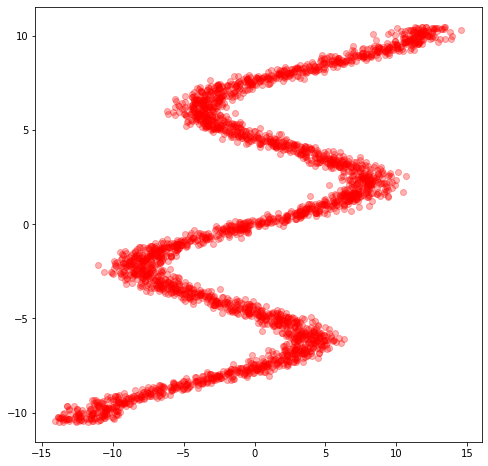

In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import random
## Generating some data:
NSAMPLE = 3000

y_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
x_data = x_data.reshape((NSAMPLE, 1))

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

In [10]:
from tensorflow import keras
import mdn

N_HIDDEN = 15  # number of hidden units in the Dense layer
N_MIXES = 10  # number of mixture components
OUTPUT_DIMS = 2  # number of real-values predicted by each mixture component

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model.add(mdn.MDN(1, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(1,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
mdn_1 (MDN)                  (None, 30)                480       
Total params: 750
Trainable params: 750
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(x=x_data, y=y_data, batch_size=128, epochs=5, validation_split=0.15)

Train on 2550 samples, validate on 450 samples
Epoch 1/5
2550/2550 [==============================] - 5s 2ms/sample - loss: 7.6364 - val_loss: 6.9233
Epoch 2/5
2550/2550 [==============================] - 0s 37us/sample - loss: 6.3754 - val_loss: 5.8040
Epoch 3/5
2550/2550 [==============================] - 0s 36us/sample - loss: 5.2765 - val_loss: 4.8083
Epoch 4/5
2550/2550 [==============================] - 0s 36us/sample - loss: 4.4869 - val_loss: 4.2593
Epoch 5/5
2550/2550 [==============================] - 0s 34us/sample - loss: 4.0851 - val_loss: 3.9728


In [12]:
# Save model if you want to.
model.save("MDN-1D-sine-prediction-model.h5")

In [14]:
# Load the model if you want to.
# To load models from file, you need to supply the layer and loss function as custom_objects:
model = keras.models.load_model('MDN-1D-sine-prediction-model.h5', 
                                custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(1, N_MIXES)})

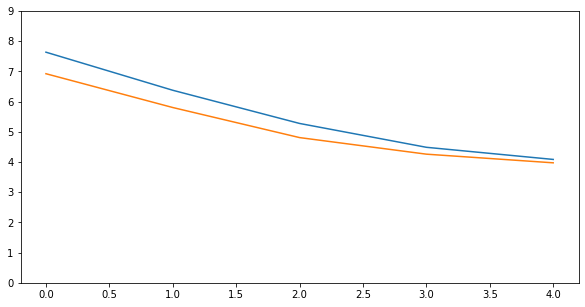

In [15]:
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [16]:
## Sample on some test data:
x_test = np.float32(np.arange(-15,15,0.01))
NTEST = x_test.size
print("Testing:", NTEST, "samples.")
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

# Make predictions from the model
y_test = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Sample from the predicted distributions
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test, 1, N_MIXES,temp=1.0)

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES]),1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES:2*N_MIXES]),1, y_test)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[2*N_MIXES:])),1, y_test)

Testing: 3000 samples.


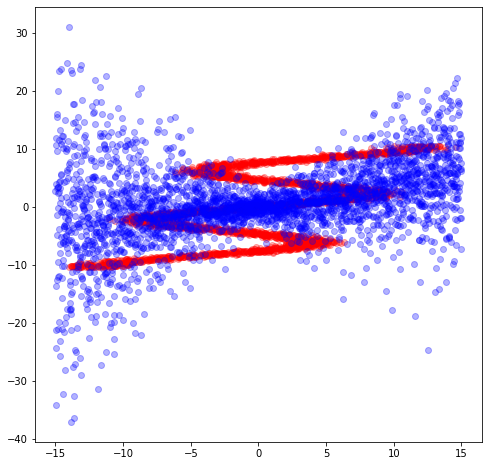

In [17]:
# Plot the samples
plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test, y_samples[:,:,0], 'bo',alpha=0.3)
plt.show()
# These look pretty good!

In [20]:
import mdn
import keras
N_HIDDEN = 10
N_MIXES = 1
model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(mdn.MDN(1, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(1, N_MIXES), optimizer=keras.optimizers.Adam())
model.save('test_save.h5')
m_2 = keras.models.load_model('test_save.h5', custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(1, N_MIXES)})

TypeError: The added layer must be an instance of class Layer. Found: <class 'mdn.MDN'>